# Load Data

In [1]:
import pandas as pd

# Load Gold H1 data
data = pd.read_csv('data.csv')

# Set date oclumn to datetime
data['Local time'] = pd.to_datetime(data['Local time'], format='%d.%m.%Y %H:%M:%S.%f GMT%z', utc=True)

# change local time name to date
data.rename(columns={'Local time': 'Date'}, inplace=True)

# set index to date
data.set_index('Date', inplace=True)

# drop rows with volume = 0
data = data[data['Volume'] != 0]

# print first 5 rows
print(len(data))
data.head()

31890


,Open,High,Low,Close,Volume
Date,,,,,
2018-01-01 23:00:00+00:00,1302.922,1307.602,1302.231,1306.711,1.626430e+06
2018-01-02 00:00:00+00:00,1306.711,1307.308,1305.211,1306.292,2.392190e+06
2018-01-02 01:00:00+00:00,1306.291,1306.952,1304.171,1306.141,2.997380e+06
2018-01-02 02:00:00+00:00,1306.142,1306.772,1305.418,1305.949,2.441420e+06
2018-01-02 03:00:00+00:00,1305.941,1307.422,1305.381,1306.438,2.557650e+06


# ZigZag Indicator

In [2]:
import numpy as np
import ta

def time_price_distance(v1, v2, t1, t2, atr):
    return abs(v2 - v1) / atr + abs(t2 - t1) / 4

def extract_async_peaks(data, left_alpha, right_alpha, atr_window, arrow_margin_plot_coef=0.5):
    # Intialize max_peaks and min_peaks with NaN
    max_peaks, min_peaks = [np.nan]*len(data), [np.nan]*len(data)

    # Extract local max peaks
    for i in range(atr_window, len(data)):
        atr = data['ATR'][i]
        is_max = True
        # Right side check
        for j in range(i+1, len(data)):
            if data['High'][j] > data['High'][i]:
                is_max = False
                break
            if time_price_distance(data['High'][i], data['Low'][j], i, j, atr) > right_alpha:
                break
        # Left side check
        if is_max:
            for j in range(i-1, 0, -1):
                if data['High'][j] > data['High'][i]:
                    is_max = False
                    break
                if time_price_distance(data['High'][i], data['Low'][j], i, j, atr) > left_alpha:
                    break
        if is_max:
            max_peaks[i] = data['High'][i] + arrow_margin_plot_coef * atr

    # Extract local min peaks
    for i in range(atr_window, len(data)):
        atr = data['ATR'][i]
        is_min = True
        # Right side check
        for j in range(i+1, len(data)):
            if data['Low'][j] < data['Low'][i]:
                is_min = False
                break
            if time_price_distance(data['Low'][i], data['High'][j], i, j, atr) > right_alpha:
                break
        # Left side check
        if is_min:
            for j in range(i-1, 0, -1):
                if data['Low'][j] < data['Low'][i]:
                    is_min = False
                    break
                if time_price_distance(data['Low'][i], data['High'][j], i, j, atr) > left_alpha:
                    break
        if is_min:
            min_peaks[i] = data['Low'][i] - arrow_margin_plot_coef * atr
    
    # remove peaks that are in a sequence
    for i in range(atr_window, len(data)):
        if not np.isnan(max_peaks[i]):
            # check for next peak (it sould be a min peak)
            for j in range(i+1, len(data)):
                if np.isnan(max_peaks[j]):
                    break
                if not np.isnan(max_peaks[j]):
                    max_peaks[j] = np.nan
        if not np.isnan(min_peaks[i]):
            # check for next peak (it sould be a max peak)
            for j in range(i+1, len(data)):
                if np.isnan(min_peaks[j]):
                    break
                if not np.isnan(min_peaks[j]):
                    min_peaks[j] = np.nan

    # remove peaks in a same candle
    for i in range(atr_window, len(data)):
        if not np.isnan(max_peaks[i]) and not np.isnan(min_peaks[i]):
            if data['Close'][i] > data['Open'][i]:
                min_peaks[i] = np.nan
            else:
                max_peaks[i] = np.nan
    
    return max_peaks, min_peaks

def extract_middle_paeks(data, alpha, atr_window, arrow_margin_plot_coef=0.5):
    # Intialize max_peaks and min_peaks with NaN
    max_middle_peaks, min_middle_peaks = extract_async_peaks(data, alpha, alpha, atr_window, arrow_margin_plot_coef=0.5)

    # fill between middle peaks
    for i in range(atr_window, len(data)):
        if not np.isnan(max_middle_peaks[i]):
            # check for next peak (it sould be a min peak)
            for j in range(i+1, len(data)):
                if not np.isnan(max_middle_peaks[j]):
                    # find min index between i and j
                    min_index = np.argmin(data['Low'][i+1:j]) + i+1
                    min_middle_peaks[min_index] = data['Low'][min_index] - arrow_margin_plot_coef * data['ATR'][min_index]
                    break
                if not np.isnan(min_middle_peaks[j]):
                    break
        if not np.isnan(min_middle_peaks[i]):
            # check for next peak (it sould be a max peak)
            for j in range(i+1, len(data)):
                if not np.isnan(min_middle_peaks[j]):
                    # find max index between i and j
                    max_index = np.argmax(data['High'][i+1:j]) + i+1
                    max_middle_peaks[max_index] = data['High'][max_index] + arrow_margin_plot_coef * data['ATR'][max_index]
                    break
                if not np.isnan(max_middle_peaks[j]):
                    break
    
    return max_middle_peaks, min_middle_peaks

def extract_list_of_lines(data):
    lines = []
    trends = []
    start_point, end_point = None, None
    trend = 'w'
    for i in range(len(data)):
        if not np.isnan(data['MaxMiddlePeaks'][i]):
            if end_point is not None:
                start_point = end_point
            end_point = (data.index[i], data['High'][i])
            if start_point is not None:
                lines.append([start_point, end_point])
                trends.append(trend)
        if not np.isnan(data['MinMiddlePeaks'][i]):
            if end_point is not None:
                start_point = end_point
            end_point = (data.index[i], data['Low'][i])
            if start_point is not None:
                lines.append([start_point, end_point])
                trends.append(trend)
        if not np.isnan(data['MaxPeaks'][i]):
            trend = 'b'
        elif not np.isnan(data['MinPeaks'][i]):
            trend = 'r'
    return lines, trends

atr_window = 200
left_alpha = 10
right_alpha = 2
arrow_margin_plot_coef = 0.5

data['ATR'] = ta.volatility.average_true_range(data['High'], data['Low'], data['Close'], window=atr_window, fillna=False)
data['MaxPeaks'], data['MinPeaks'] = extract_async_peaks(data, left_alpha, right_alpha, atr_window, arrow_margin_plot_coef)
data['MaxMiddlePeaks'], data['MinMiddlePeaks'] = extract_middle_paeks(data, right_alpha, atr_window, arrow_margin_plot_coef)

# Plot

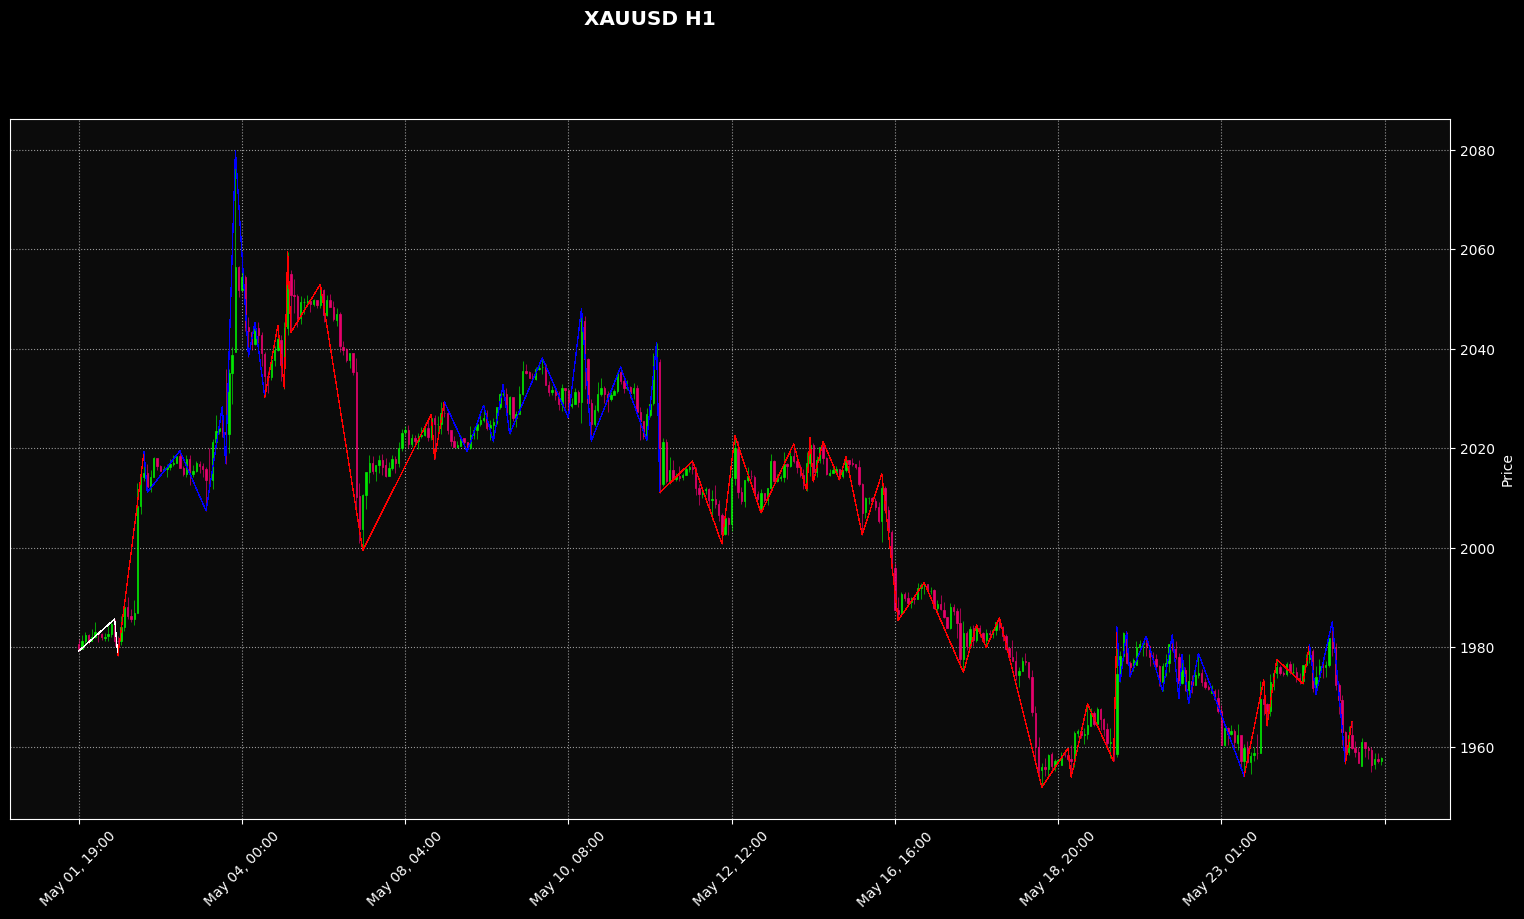

In [3]:
import mplfinance as mpf

data_window = 400
strat_candle = 1

# ZigZag Lines
zigzag_lines, trends = extract_list_of_lines(data[-strat_candle-data_window:-strat_candle])

# create custom style
mc = mpf.make_marketcolors(up='#00ff00',down='#ff0077',inherit=True)
s = mpf.make_mpf_style(base_mpf_style='nightclouds', marketcolors=mc, gridstyle=':', y_on_right=True)
# plot candlestick chart
title = 'XAUUSD H1'
mpf.plot(data[-strat_candle-data_window:-strat_candle], type='candle', style=s, title=title, figsize=(20, 10), figscale=1,
          alines=dict(alines = zigzag_lines, colors = trends, linewidths=0.2))

# feature extraction 

## b)

In [38]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

In [39]:
zigzag_lines[:2]

[[(Timestamp('2023-05-01 19:00:00+0000', tz='UTC'), 1979.235),
  (Timestamp('2023-05-02 07:00:00+0000', tz='UTC'), 1985.665)],
 [(Timestamp('2023-05-02 07:00:00+0000', tz='UTC'), 1985.665),
  (Timestamp('2023-05-02 08:00:00+0000', tz='UTC'), 1978.324)]]

In [40]:
num = len(zigzag_lines)
data=[]
for i in range(num):
    start_time , start_price = zigzag_lines[i][0]
    end_time , end_price = zigzag_lines[i][1]
    data.append([start_time,end_time,start_price,end_price,trends[i]])

data[:2]

[[Timestamp('2023-05-01 19:00:00+0000', tz='UTC'),
  Timestamp('2023-05-02 07:00:00+0000', tz='UTC'),
  1979.235,
  1985.665,
  'w'],
 [Timestamp('2023-05-02 07:00:00+0000', tz='UTC'),
  Timestamp('2023-05-02 08:00:00+0000', tz='UTC'),
  1985.665,
  1978.324,
  'w']]

In [41]:
datasets={}
previous = [2,3,4]
for p in previous:
    d1 = []
    for i in range(p , num):
        d2 = []
        for j in range (p):
            d2+=data[i-j]
        d1.append(d2)
    datasets[p] = d1

## c)

In [87]:
def KMeans_imp(data,cluster=5):
    data = np.array(data)
    b_trend_data = data[data[:, 4] == 'b']
    r_trend_data = data[data[:, 4] == 'r']
    
    r_X = r_trend_data[:, 2:4]  
    r_kmeans = KMeans(n_clusters=cluster)
    r_labels = r_kmeans.fit_predict(r_X)
    r_centers = r_kmeans.cluster_centers_
    
    b_X = b_trend_data[:, 2:4] 
    b_kmeans = KMeans(n_clusters=cluster)
    b_labels = b_kmeans.fit_predict(b_X)
    b_centers = b_kmeans.cluster_centers_
    
    
    colors = ['blue', 'green', 'red', 'purple', 'orange']
 
    plt.figure(figsize=(8, 6))
    plt.title(f'Blue Trend Patterns')
    plt.scatter(b_X[:, 0], b_X[:, 1], c=b_labels, cmap='viridis')
    plt.scatter(b_centers[:, 0], b_centers[:, 1], c='red', marker='X', s=100, label='Centers')
    plt.xlabel('Start Price')
    plt.ylabel('End Price')
    plt.legend()
    plt.show()
    
    fig, axs = plt.subplots(1, cluster, figsize=(15, 5))
    fig.suptitle(f'Blue Trend Patterns')

    for c in range(cluster):
        cluster_indices = np.where(b_labels == c)[0]
        for index in cluster_indices:
            s = b_trend_data[index, 2]
            e = b_trend_data[index, 3]
            axs[c].plot([0, 1], [s, e], color=colors[c])

    plt.show()

    
    plt.figure(figsize=(8, 6))
    plt.title(f'Red Trend Patterns')
    plt.scatter(r_X[:, 0], r_X[:, 1], c=r_labels, cmap='viridis')
    plt.scatter(r_centers[:, 0], r_centers[:, 1], c='red', marker='X', s=100, label='Centers')
    plt.xlabel('Start Price')
    plt.ylabel('End Price')
    plt.legend()
    plt.show()
    
    fig, axs = plt.subplots(1, cluster, figsize=(15, 5))
    fig.suptitle(f'Red Trend Patterns')

    for c in range(cluster):
        cluster_indices = np.where(r_labels == c)[0]
        for index in cluster_indices:
            s = r_trend_data[index, 2]
            e = r_trend_data[index, 3]
            axs[c].plot([0, 1], [s, e], color=colors[c])

    plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


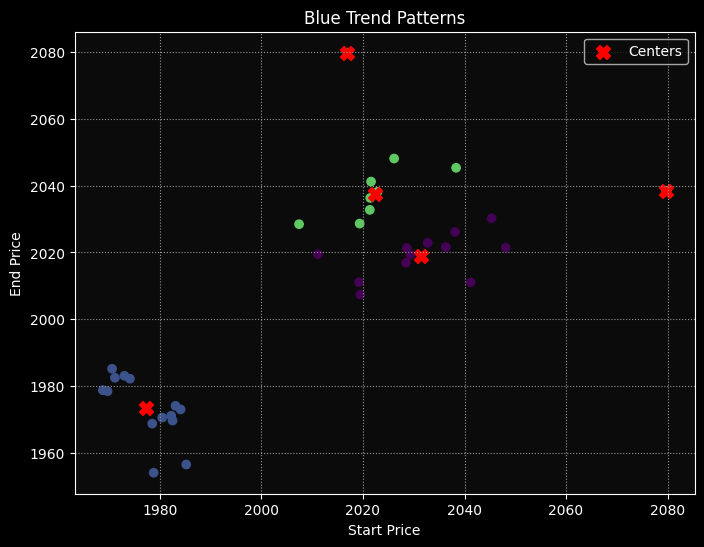

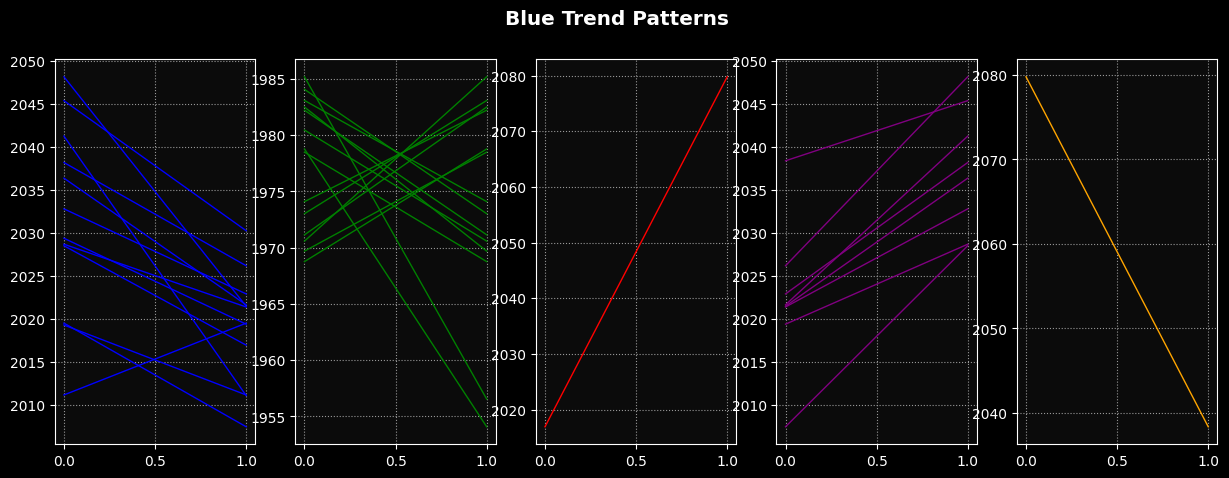

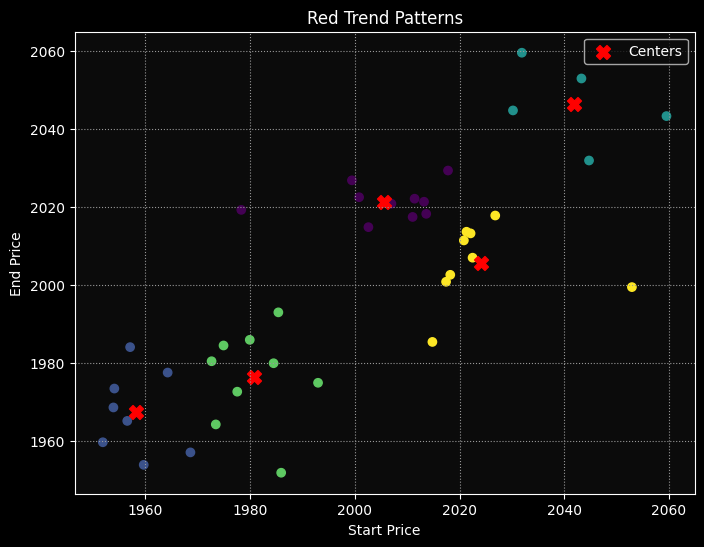

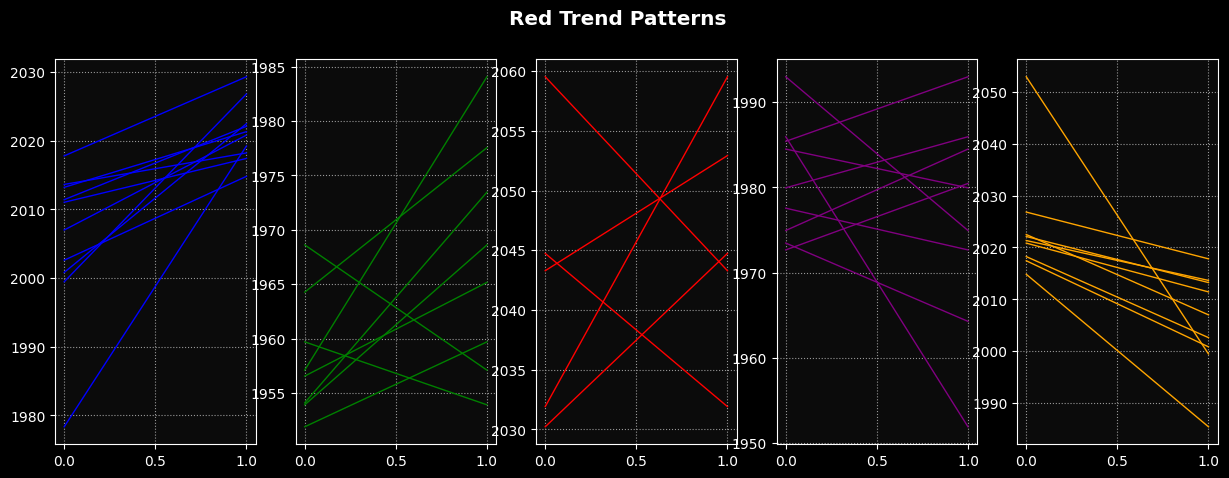

In [88]:
KMeans_imp(datasets[2])

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


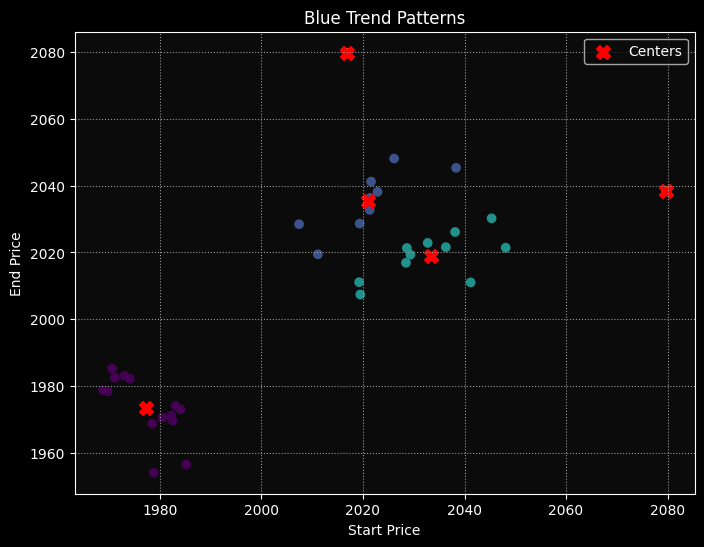

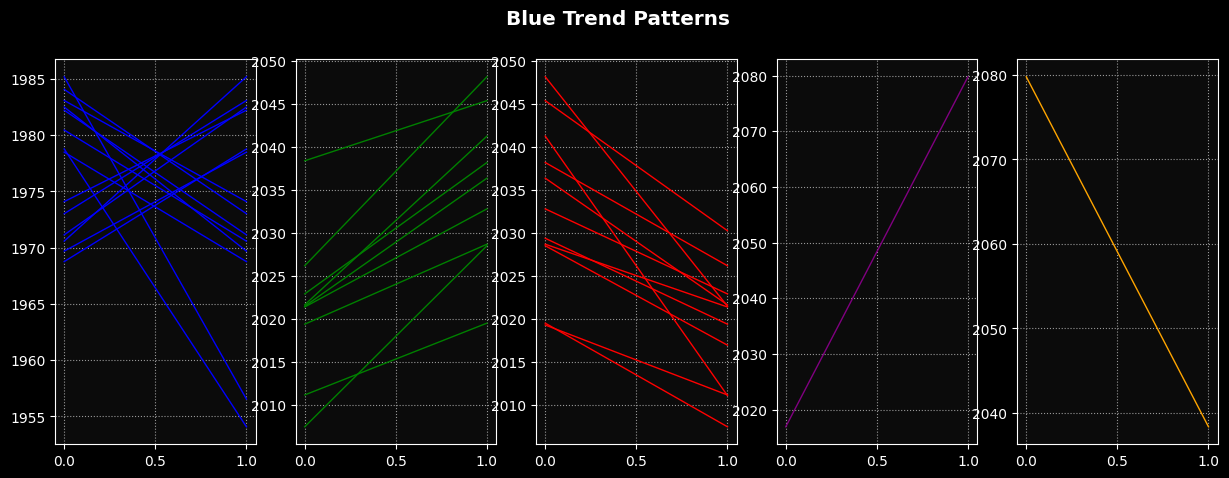

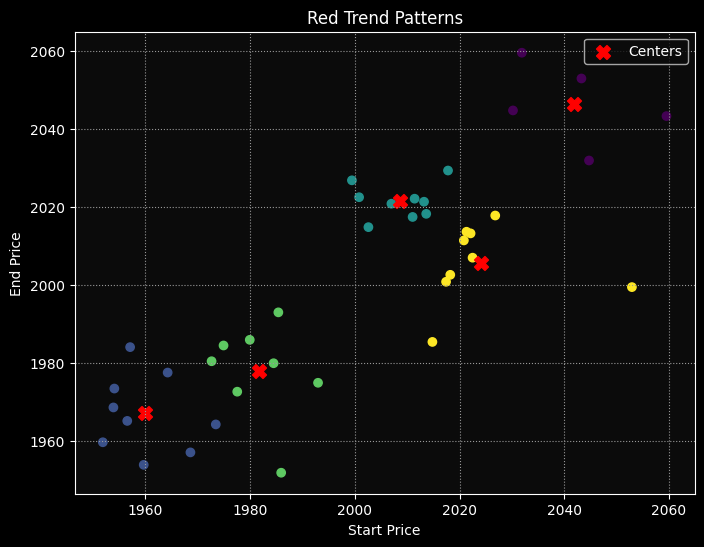

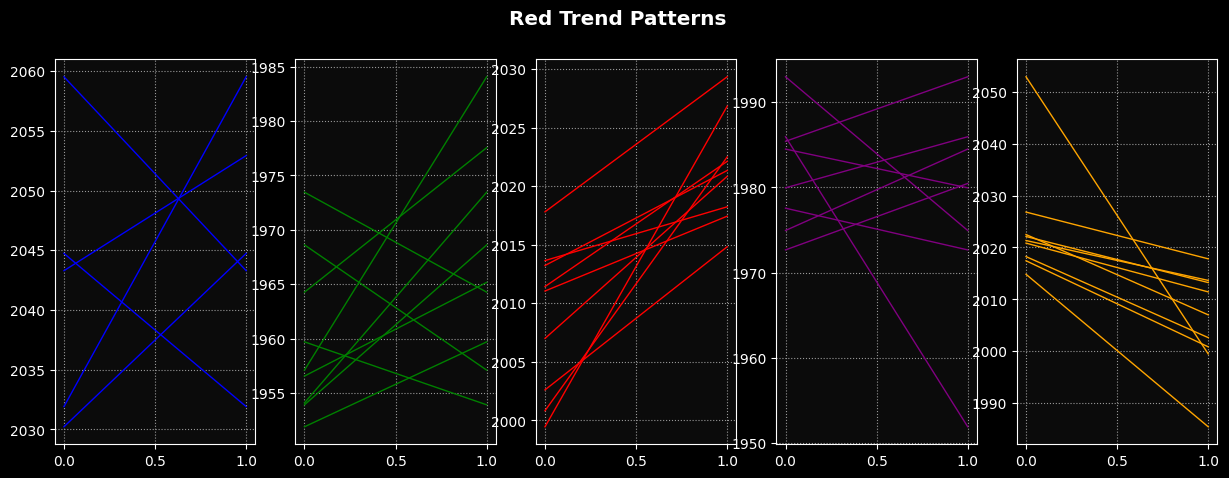

In [78]:
KMeans_imp(datasets[3])

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


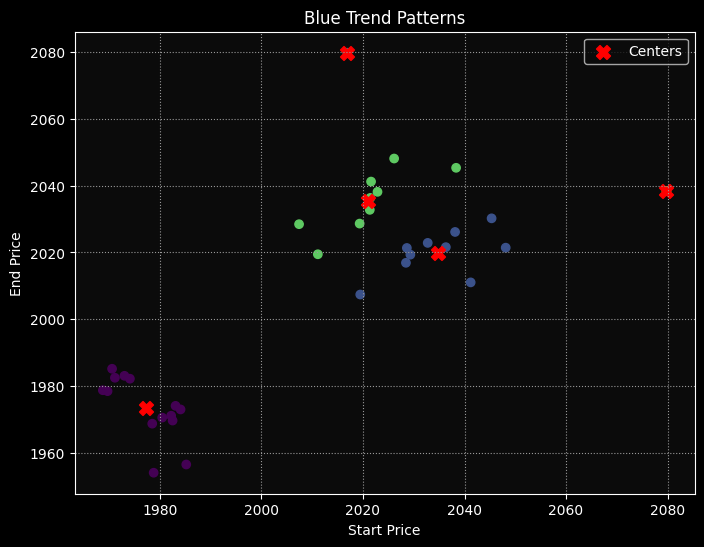

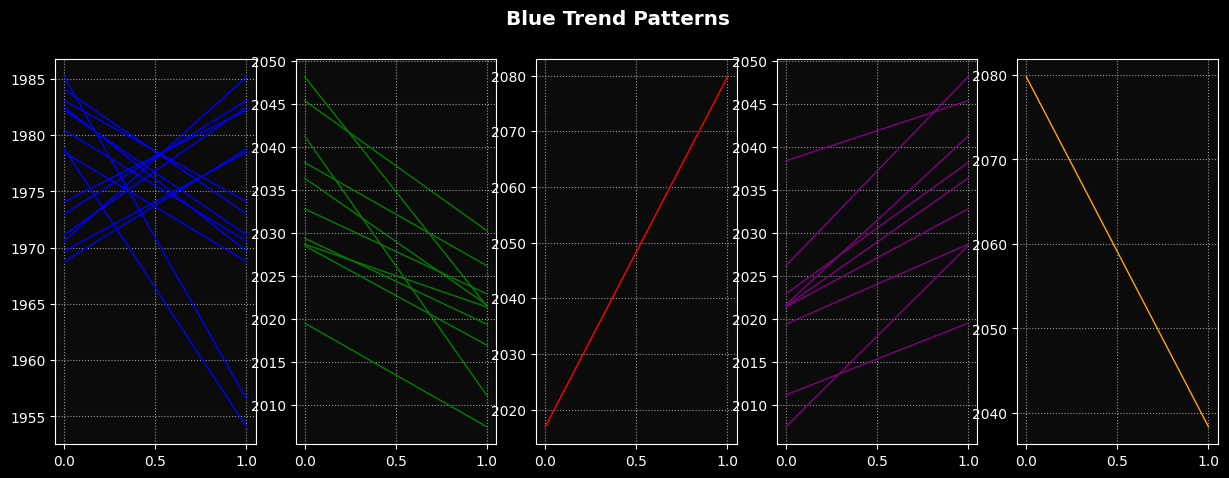

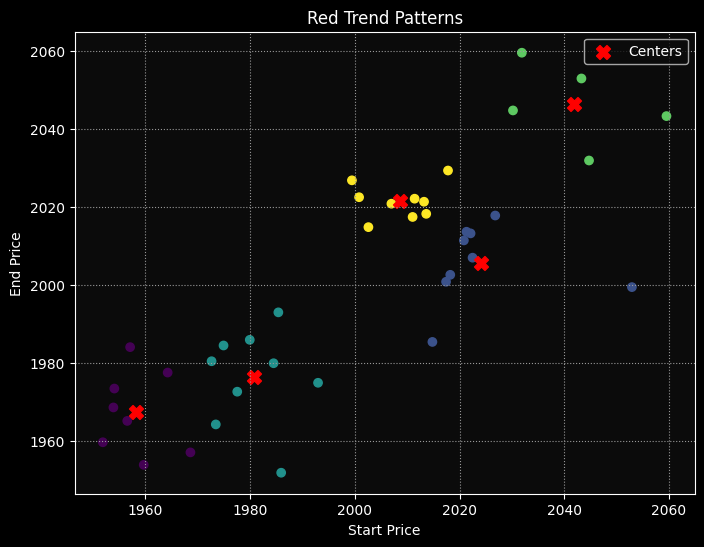

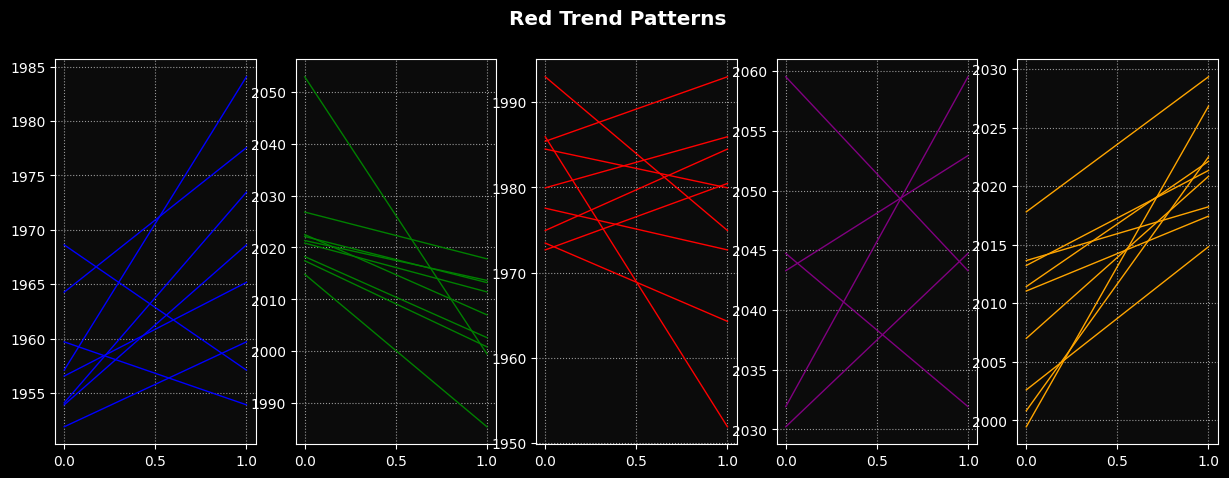

In [79]:
KMeans_imp(datasets[4])

## d)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


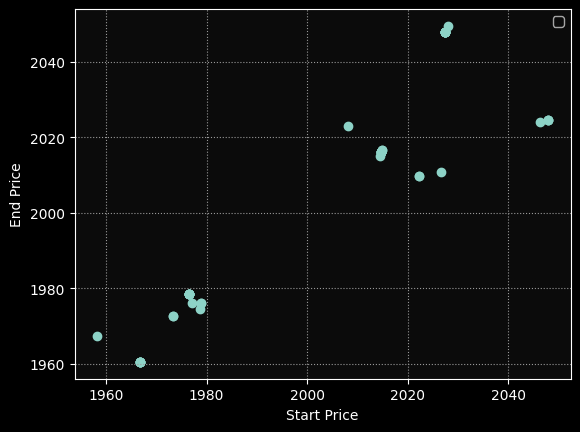

In [80]:
X = np.array(datasets[2])[:, 2:4] 
centershist = {}
for i in range(1, 50):
    kmeans = KMeans(n_clusters=5, max_iter=i)
    labels = kmeans.fit_predict(X)
    centers = kmeans.cluster_centers_
    centershist[i]=centers

hist={0:[],1:[],2:[],3:[],4:[]}
for _,i in centershist.items():
    hist[0].append(i[0].tolist())
    hist[1].append(i[1].tolist())
    hist[2].append(i[2].tolist())
    hist[3].append(i[3].tolist())
    hist[4].append(i[4].tolist())


hist[0] = np.array(hist[0])
plt.scatter(hist[0][:, 0], hist[0][:, 1])
plt.xlabel('Start Price')
plt.ylabel('End Price')
plt.legend()
                        
plt.show()

## d)

In [83]:
def imp_elbow(data):
    data = np.array(data)
    wcss = []

    for i in range(1, 15):
        clustering = KMeans(n_clusters=i)
        clustering.fit(data[:,2:4])
        wcss.append(clustering.inertia_)
        
    plt.plot(range(1, 15), wcss, marker='o')
    plt.xlabel('Number of clusters')
    plt.ylabel('Wcss')
                        
    plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

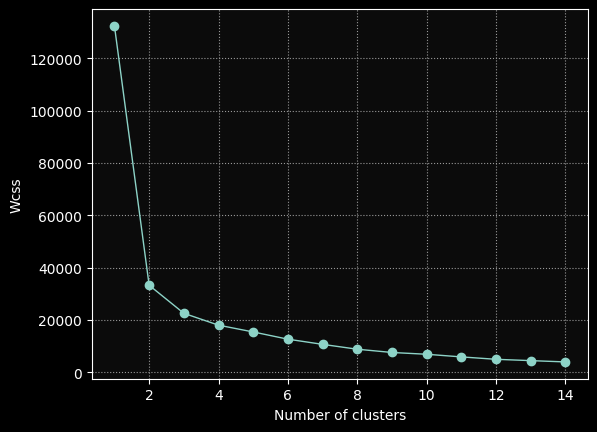

In [84]:
imp_elbow(datasets[2])

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

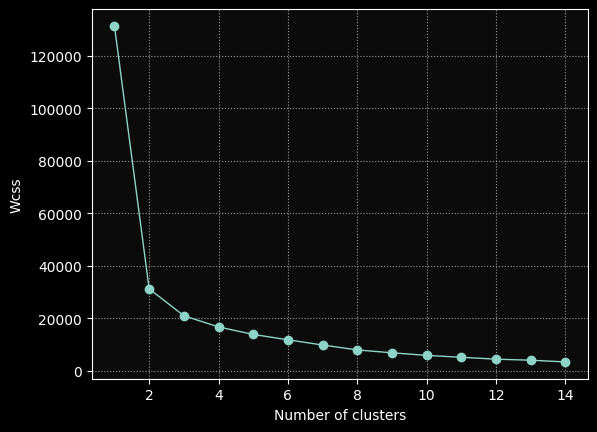

In [85]:
imp_elbow(datasets[3])

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

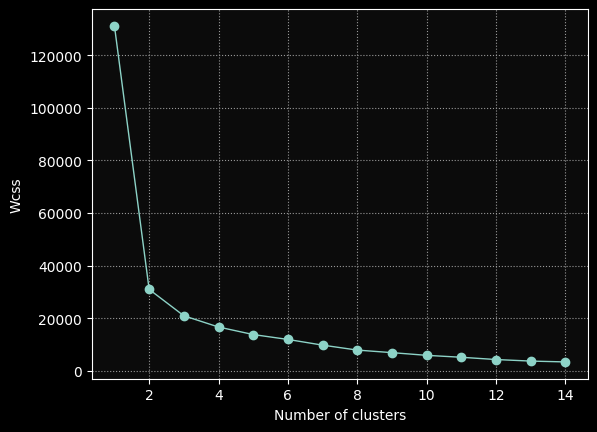

In [86]:
imp_elbow(datasets[4])

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


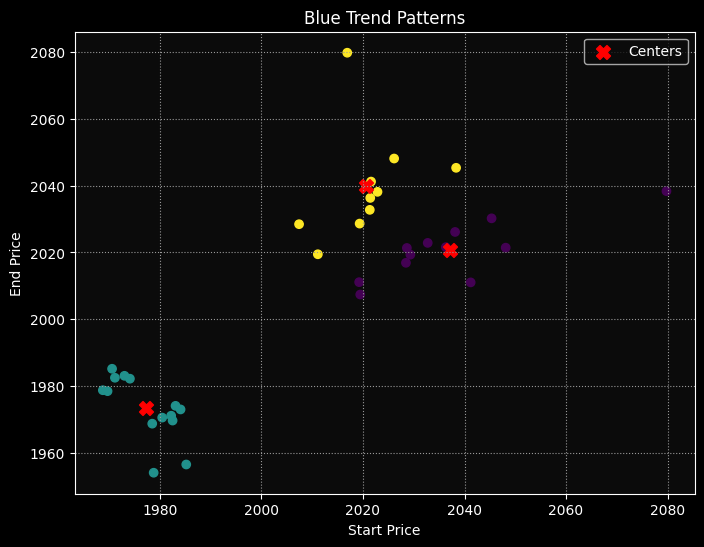

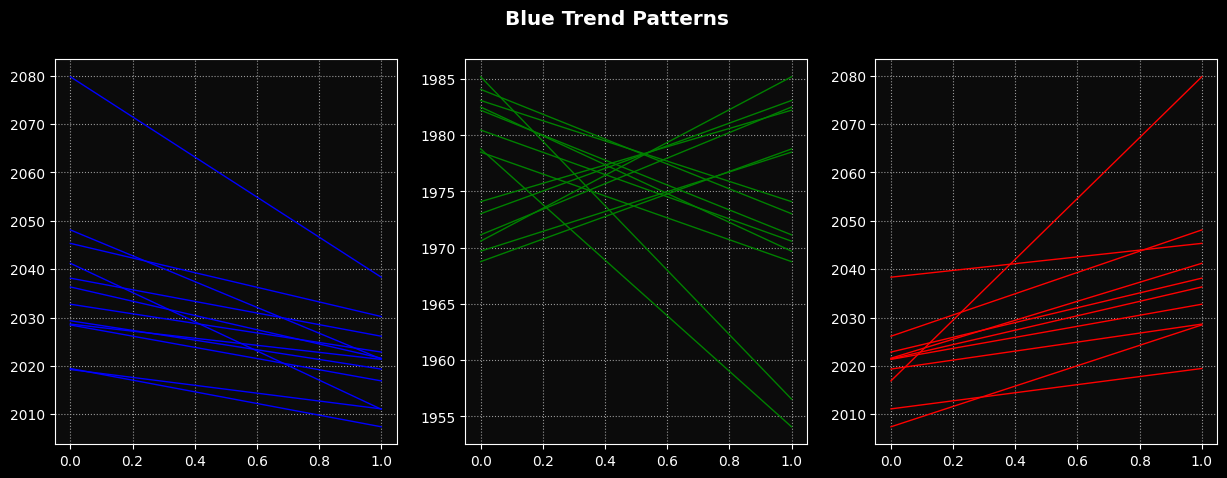

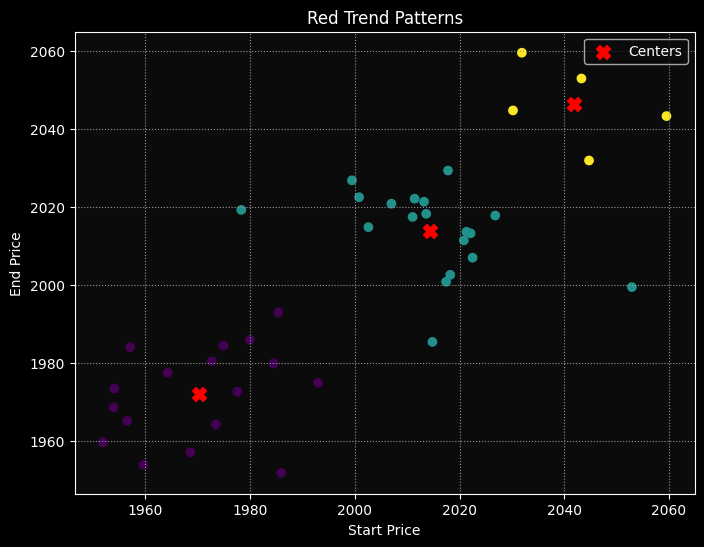

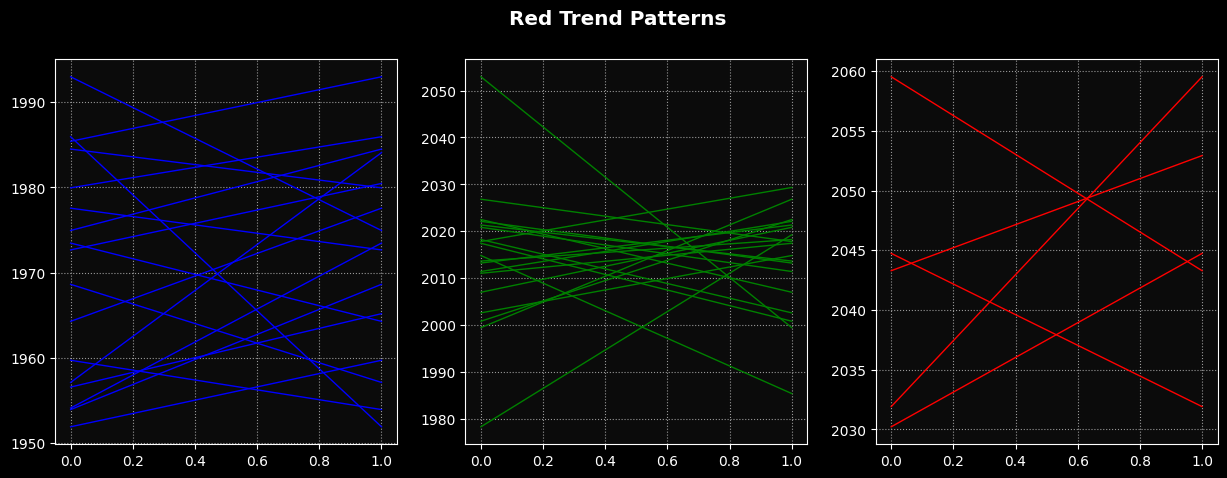

In [89]:
KMeans_imp(datasets[2],3)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


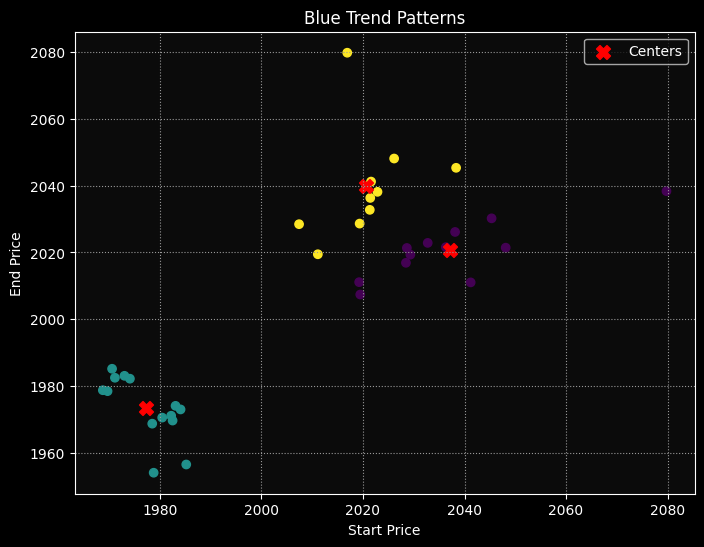

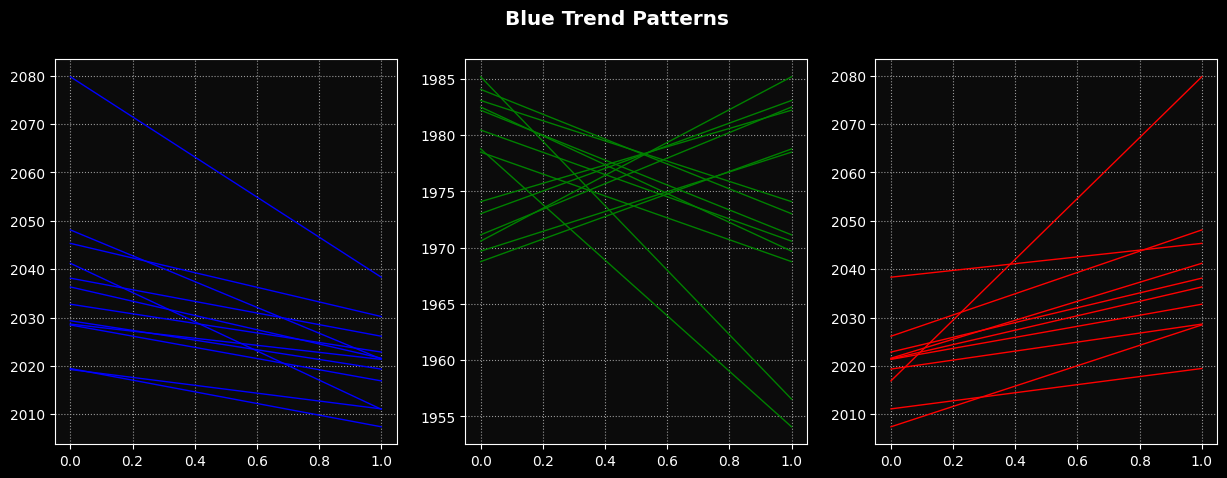

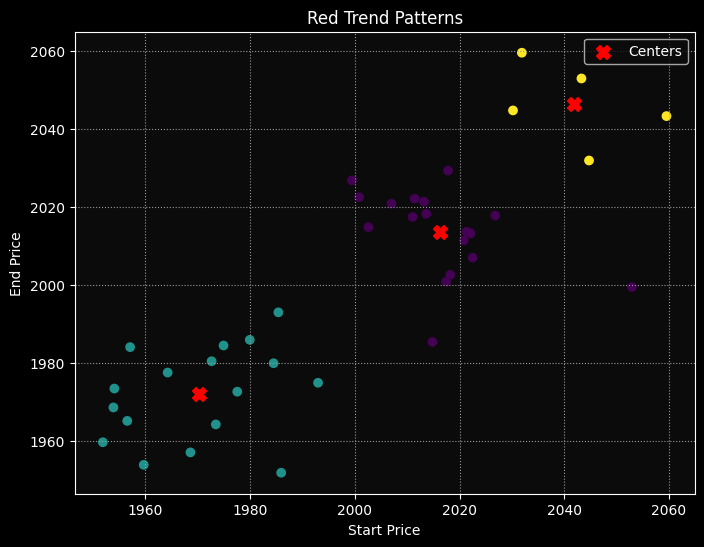

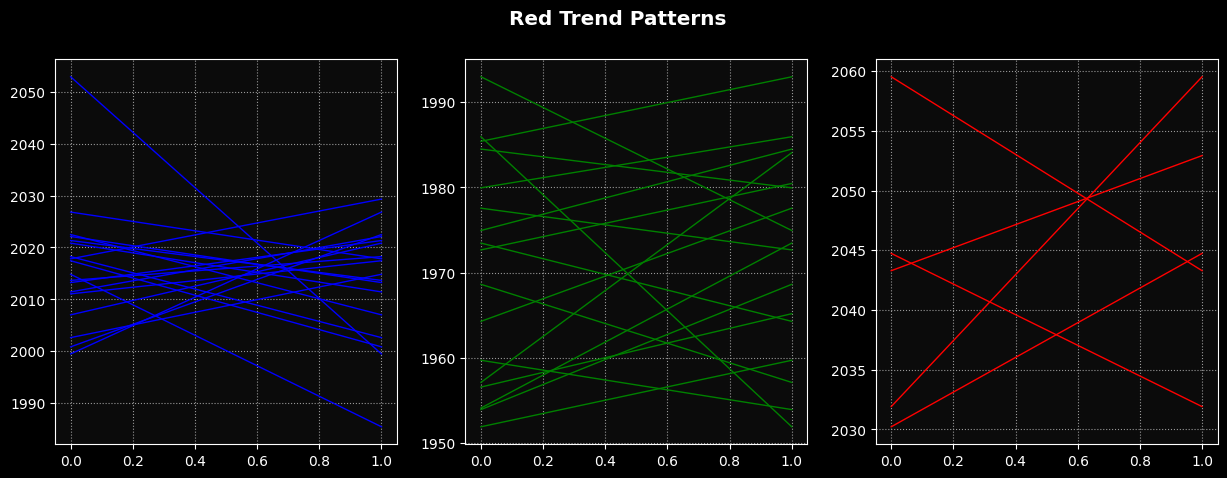

In [90]:
KMeans_imp(datasets[3],3)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


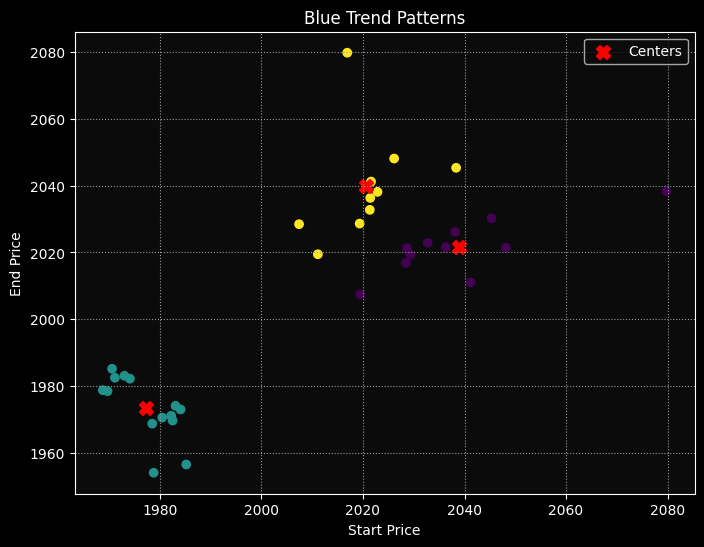

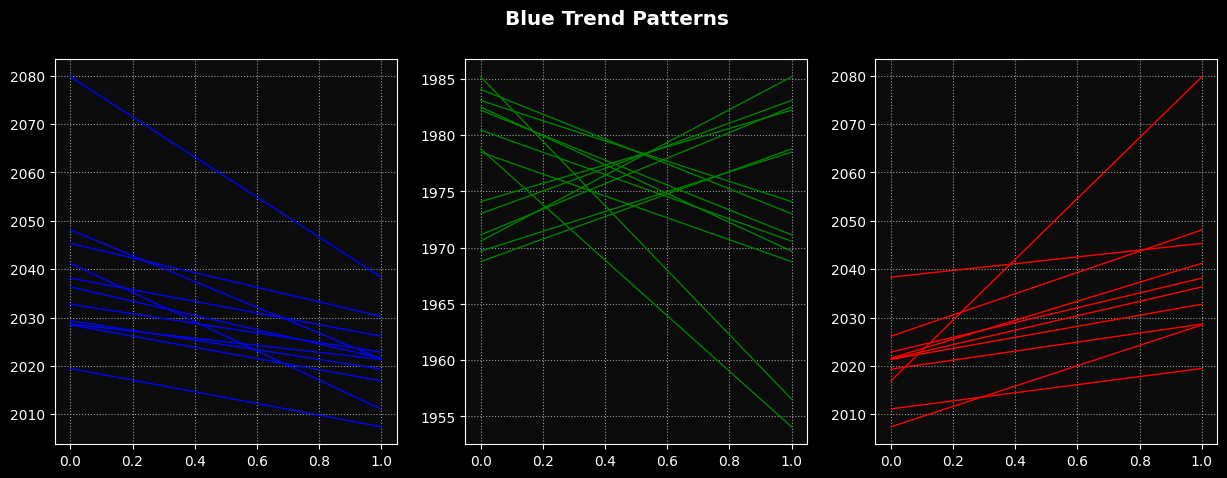

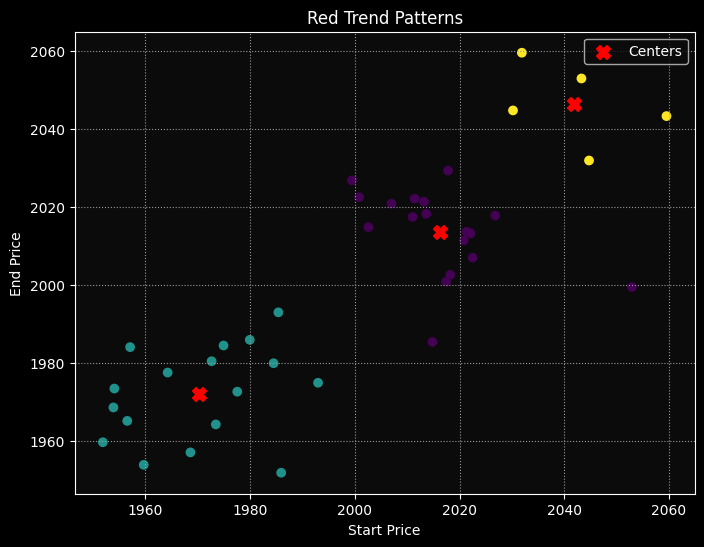

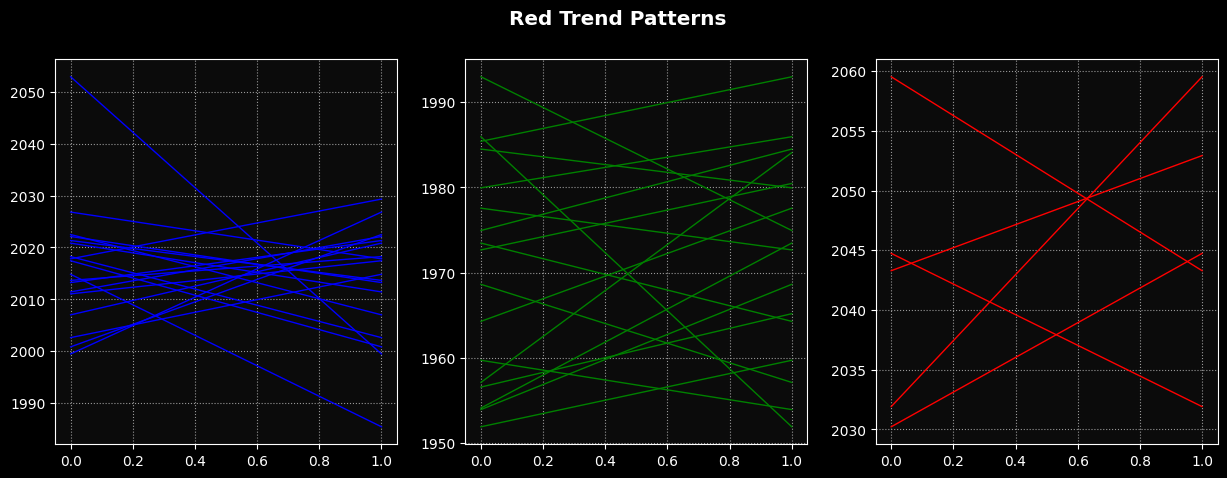

In [91]:
KMeans_imp(datasets[4],3)